In [23]:
import time
import casadi
import example_robot_data as robex
import numpy as np
from utils.Lagrange import *
from utils.LGL_collocation import LGL_collocation
from utils.LocalChart import *
import pinocchio as pin
from pinocchio import casadi as cpin
import matplotlib.pyplot as plt
import scipy

In [24]:
robot = robex.load("ur10")
model = robot.model
data = robot.data

cmodel = cpin.Model(model)
cdata = cmodel.createData()
nq = model.nq   # Number of joints
nv = model.nv   # Number of DOF
nx = nq + nv    # Number of states
cx = casadi.SX.sym("x", nx, 1)
ctau = casadi.SX.sym("tau", nv, 1)
cacc = cpin.aba(cmodel, cdata, cx[:nq], cx[nq:], ctau) # Forward dynamics

# Joint limits
lowerVelocityLimit = np.pi/2 * np.array([-1, -1, -1, -1, -1, -1])  # rad/s
upperVelocityLimit = np.pi/2 * np.array([1, 1, 1, 1, 1, 1])
lowerTorqueLimit = 100 * np.array([-1, -1, -1, -1, -1, -1]) 
upperTorqueLimit = 100 * np.array([1, 1, 1, 1, 1, 1])
print(model.upperPositionLimit)
print(model.lowerPositionLimit)

waypoints = np.array([[0, np.pi/4, 0, 0, 0, 0], 
                      [-np.pi/6, np.pi/3, np.pi/6, -np.pi/6, -np.pi/3, 0],
                      [-np.pi/4, np.pi/4, np.pi/3, 0, -np.pi/6, 0]])
q0 = waypoints[0]
robot.q0 = q0
qT = waypoints[-1]
tau0 = pin.rnea(model, data, q0, np.zeros(nv), np.zeros(nv))
tauT = pin.rnea(model, data, qT, np.zeros(nv), np.zeros(nv))
print(tau0)
print(tauT)

[6.28318531 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531]
[-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]
[-8.88178420e-16 -8.52573478e+01 -2.38834632e+01  1.62120800e-01
  0.00000000e+00  0.00000000e+00]
[ 3.55271368e-15 -5.23511289e+01  9.02275572e+00  2.21461131e-01
  0.00000000e+00  0.00000000e+00]


In [25]:
Ntp = 20     # Number of collocation points / basis (degree: Ntp-1)
Np = waypoints.shape[0]-1  # Number of phase (dersired waypoints: N+1)
T = Np*Ntp  # Number of total collocation points / optimization variables

LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp)
DL,_ = differentiation_matrix(Ntp, LGL_Pts)

LGL = LGL_collocation(Ntp, nq, nv)
StatesDiff, StateDiff, LocalsDiff, LocalDiff= LGL.getDiffFuncs()

Feq = casadi.Function(
    "Dyn",
    [cx, ctau],
    [casadi.vertcat(cx[nq:], cacc)],
)

In [26]:
opti = casadi.Opti()
# Optimization variables
var_xs = [opti.variable(nx) for _ in range(T)]
var_us = [opti.variable(nv) for _ in range(T)]
var_deltaT = [opti.variable(1) for _ in range(Np)]

In [27]:
# Constraints
for i in range(Np):
    opti.subject_to(var_deltaT[i] >= 0.0)

    for tp in range(Ntp):
        t = i*Ntp + tp
        # dynamics
        opti.subject_to(StatesDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[tp,:]) 
                        == Feq(var_xs[t], var_us[t]))
        
        # joint constraints
        opti.subject_to(var_xs[t][:nq] <= model.upperPositionLimit)
        opti.subject_to(var_xs[t][:nq] >= model.lowerPositionLimit)
        # joint velocity constraints
        opti.subject_to(var_xs[t][nq:] <= upperVelocityLimit)
        opti.subject_to(var_xs[t][nq:] >= lowerVelocityLimit)
        # torque constraints
        opti.subject_to(var_us[t] <= upperTorqueLimit)
        opti.subject_to(var_us[t] >= lowerTorqueLimit)

# waypoints constraints (N-1 middle waypoints)
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp][:nq] == waypoints[i])

# continuity
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp-1] == var_xs[i*Ntp])
    opti.subject_to(var_us[i*Ntp-1] == var_us[i*Ntp])

# continuity of derivatives
for i in range(Np-1):
    opti.subject_to(StatesDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[Ntp-1,:]) 
                    == StatesDiff(casadi.vertcat(*var_xs[(i+1)*Ntp: (i+2)*Ntp]), var_deltaT[i+1], DL[0,:]))
    
    opti.subject_to(LocalDiff(casadi.vertcat(*var_us[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[Ntp-1,:])
                   == LocalDiff(casadi.vertcat(*var_us[(i+1)*Ntp: (i+2)*Ntp]), var_deltaT[i], DL[0,:]))

# boundary conditions
opti.subject_to(var_xs[0][:nq] == q0)
opti.subject_to(var_xs[-1][:nq] == qT)
opti.subject_to(var_xs[0][nq:] == 0)
opti.subject_to(var_xs[-1][nq:] == 0)
#opti.subject_to(var_us[0] == tau0)
#opti.subject_to(var_us[-1] == tauT)

# Objective
totalcost = 0

R = np.eye(nv)
for i in range(Np):
    for tp in range(Ntp):
        var_xs_Phase = var_xs[i*Ntp: (i+1)*Ntp]
        dq = [dq_Phase[nq:] for dq_Phase in var_xs_Phase]
        ddq = StateDiff(casadi.vertcat(*dq), var_deltaT[i], DL[tp,:])
        totalcost += var_deltaT[i]/2 * LGL_Wts[tp] * casadi.mtimes([ddq.T, R, ddq])
        
    totalcost += var_deltaT[i]

opti.minimize(totalcost)
opti.solver("ipopt") 

for x in var_xs:
    opti.set_initial(x, np.concatenate([robot.q0, np.zeros(nv)]))
for u in var_us:
    opti.set_initial(u, tau0)
for t in var_deltaT:
    opti.set_initial(t, 1)


In [28]:
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_us = [opti.value(var_u) for var_u in var_us]
    sol_T = [opti.value(var_t) for var_t in var_deltaT]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    15216
Number of nonzeros in inequality constraint Jacobian.:     1442
Number of nonzeros in Lagrangian Hessian.............:    18962

Total number of variables............................:      722
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      546
Total number of inequality constraints...............:     1442
        inequality constraints with only lower bounds:      722
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      720

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e+00 1.05e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [29]:
print(sol_T)
print(f"Total time: {sum(sol_T)}")

T_List = [0] + [sum(sol_T[:i+1]) for i in range(Np)]

[2.7328256824112853, 2.241599989545878]
Total time: 4.974425671957164


### Inverse dynamics


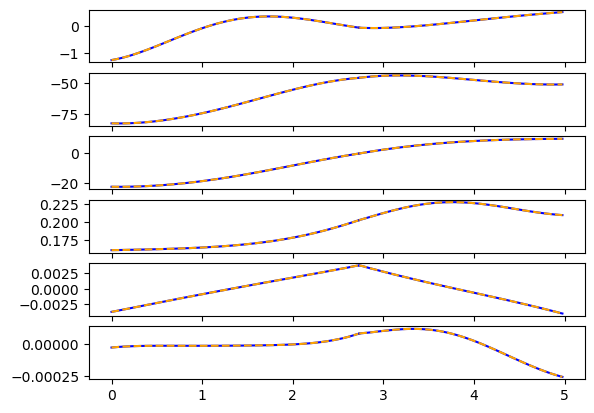

In [30]:
nsample = 100
fig, axs = plt.subplots(nv,1)
for i in range(Np):
    sample_t = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]

    t = casadi.SX.sym("t")
    inter_xs = casadi.Function(
        "xt", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )
    inter_dxs = casadi.Function(
        "dxt", 
        [t], [DiffLangrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )


    sample_q = np.array([inter_xs(t)[:nq] for t in sample_t])
    sample_dq = np.array([inter_xs(t)[nq:] for t in sample_t])
    sample_ddq = np.array([inter_dxs(t)[nv:] for t in sample_t])

    # from interpolation
    sample_u = np.array([inter_us(t) for t in sample_t])
    
    # from dynamics equations
    tau_id = np.array([pin.rnea(model, data, q, dq, ddq) for q, dq, ddq in zip(sample_q, sample_dq, sample_ddq)])
    # plot sample_u and tau
    
    for j in range(nv): 
        axs[j].plot(sample_t, sample_u[:,j], label=f'u{j}',color='blue')
        axs[j].plot(sample_t, tau_id[:,j], label=f'tau{j}',color='orange',linestyle='dashed')

plt.show()

### Forward Dynamics

'\nx = casadi.SX.sym("x", nx, 1)\nt = casadi.SX.sym(\'t\')\node = {\'x\': x, \'t\': t, \'ode\': ForwardDynamics(x,t)}\ntime_steps = np.linspace(0, sol_T[0], 51)\nopts = {\n    \'t0\':0.0,\n    \'tf\': sol_T[0],                  # Final time\n    \'abstol\': 1e-8,             # Absolute tolerance\n    \'reltol\': 1e-8,             # Relative tolerance\n    \'max_num_steps\': 10000,     # Maximum number of steps\n    \'output_t0\': True,          # Include the initial condition in the output\n    \'record_time\': True,        # Record the time steps\n    \'grid\': time_steps # Specify the grid for output steps\n}\nintegrator = casadi.integrator(\'integrator\', \'cvodes\', ode, opts)\nprint(ode)\n\n\n# ODE solver\nx0 = np.concatenate([robot.q0, np.zeros(nv)])\nresult = integrator(x0=x0)\nstates = result[\'xf\']\n\n\n# Print the intermediate steps\nfor i, time in enumerate(time_steps):\n    print(f"Time: {time}, State: {states[:, i]}")\n\n'

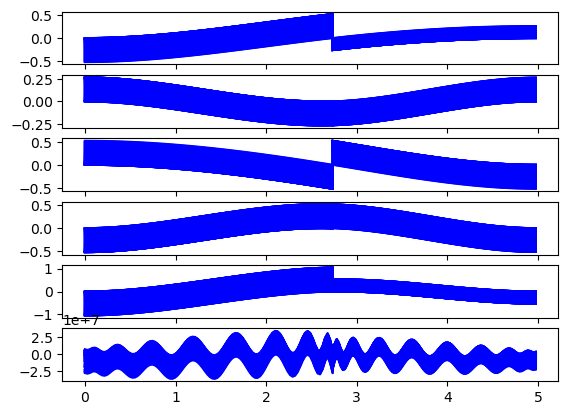

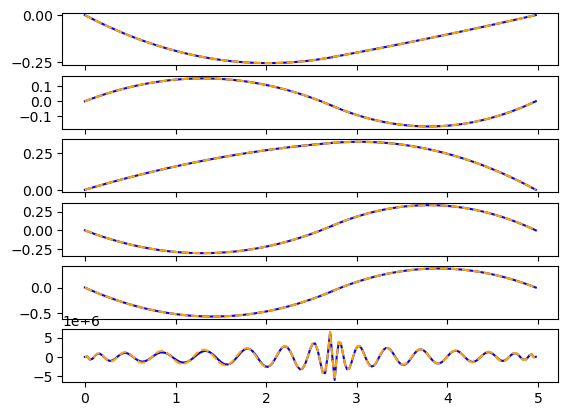

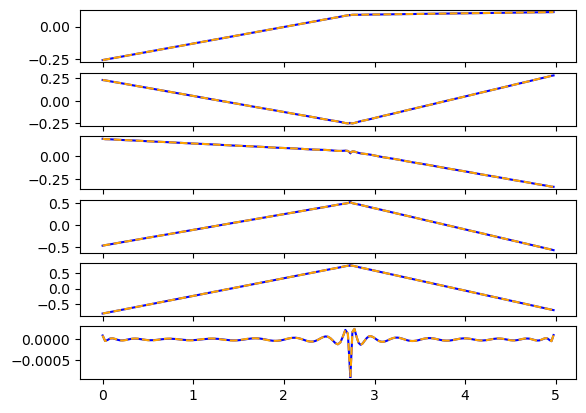

In [31]:
def ForwardDynamics(x, t, inter_us):
    q = x[:nq]
    dq = x[nq:]
    u = np.squeeze(inter_us(t))
    ddq = pin.aba(model, data, q, dq, u)
    return np.concatenate([dq, ddq])

q_forward = [None]*Np
dq_forward = [None]*Np
ddq_forward = [None]*Np

x0 = sol_xs[0]   # initial condition
for i in range(Np):
    time_grid = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]
    t = casadi.SX.sym("t")
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )
    x_forward = scipy.integrate.odeint(ForwardDynamics, x0, time_grid, args = (inter_us,))
    x0 = x_forward[-1]
    
    q_forward[i] = x_forward[:,:nq]
    dq_forward[i] = x_forward[:,nq:]
    u_grid = np.array([np.squeeze(inter_us(t)) for t in time_grid])
    ddq_forward[i] = np.array([pin.aba(model, data, q, dq, u) for q, dq, u in zip(x_forward[:,:nq], x_forward[:,nq:], u_grid)])


fig1, axs1 = plt.subplots(nq, 1)  # joint positions
fig2, axs2 = plt.subplots(nq, 1)  # joint velocities
fig3, axs3 = plt.subplots(nq, 1)  # joint accelerations

for i in range(Np):
    time_grid = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]

    t = casadi.SX.sym("t")
    inter_xs = casadi.Function(
        "xt", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )
    inter_dxs = casadi.Function(
        "dxt", 
        [t], [DiffLangrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )

    # Interpolated trajectory / Nominal trajectory
    sample_q = np.array([inter_xs(t)[:nq] for t in time_grid])
    sample_dq = np.array([inter_xs(t)[nq:] for t in time_grid])
    sample_ddq = np.array([inter_dxs(t)[nv:] for t in time_grid])


    for j in range(nq):
        axs1[j].plot(time_grid, q_forward[i][:,j]-sample_q[:,j], label=f'Integrate_q{j}',color='blue')

    for j in range(nq):
        axs2[j].plot(time_grid, dq_forward[i][:,j], label=f'Integrate_dq{j}',color='blue')
        axs2[j].plot(time_grid, sample_dq[:,j], label=f'Nominal_dq{j}',color='orange',linestyle='dashed')

    for j in range(nv):
        axs3[j].plot(time_grid, ddq_forward[i][:,j], label=f'Integrate_ddq{j}',color='blue')   # blue
        axs3[j].plot(time_grid, sample_ddq[:,j], label=f'Nominal_ddq{j}', color='orange',linestyle='dashed')   

'''
x = casadi.SX.sym("x", nx, 1)
t = casadi.SX.sym('t')
ode = {'x': x, 't': t, 'ode': ForwardDynamics(x,t)}
time_steps = np.linspace(0, sol_T[0], 51)
opts = {
    't0':0.0,
    'tf': sol_T[0],                  # Final time
    'abstol': 1e-8,             # Absolute tolerance
    'reltol': 1e-8,             # Relative tolerance
    'max_num_steps': 10000,     # Maximum number of steps
    'output_t0': True,          # Include the initial condition in the output
    'record_time': True,        # Record the time steps
    'grid': time_steps # Specify the grid for output steps
}
integrator = casadi.integrator('integrator', 'cvodes', ode, opts)
print(ode)


# ODE solver
x0 = np.concatenate([robot.q0, np.zeros(nv)])
result = integrator(x0=x0)
states = result['xf']


# Print the intermediate steps
for i, time in enumerate(time_steps):
    print(f"Time: {time}, State: {states[:, i]}")

'''